In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_csv = './data/train.csv'
images_data = './data/train/'

In [3]:
labels_df = pd.read_csv(train_csv)

In [4]:
labels_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,03772.jpg,39,46,85,51,117,50,170,50,52,...,161,62,99,115,71,141,106,147,145,136
4996,05191.jpg,25,19,40,17,52,17,74,18,28,...,77,36,50,42,30,64,53,67,62,68
4997,05226.jpg,8,12,20,11,36,12,46,14,11,...,43,16,27,27,16,34,26,37,38,35
4998,05390.jpg,11,8,29,10,56,22,72,26,22,...,68,30,48,37,26,49,36,49,45,51


In [5]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5000 non-null   object
 1   x1        5000 non-null   int64 
 2   y1        5000 non-null   int64 
 3   x2        5000 non-null   int64 
 4   y2        5000 non-null   int64 
 5   x3        5000 non-null   int64 
 6   y3        5000 non-null   int64 
 7   x4        5000 non-null   int64 
 8   y4        5000 non-null   int64 
 9   x5        5000 non-null   int64 
 10  y5        5000 non-null   int64 
 11  x6        5000 non-null   int64 
 12  y6        5000 non-null   int64 
 13  x7        5000 non-null   int64 
 14  y7        5000 non-null   int64 
 15  x8        5000 non-null   int64 
 16  y8        5000 non-null   int64 
 17  x9        5000 non-null   int64 
 18  y9        5000 non-null   int64 
 19  x10       5000 non-null   int64 
 20  y10       5000 non-null   int64 
 21  x11       5000

### Show some samples

In [104]:
test_filename = '04632.jpg'

In [112]:
img = cv2.imread(images_data+test_filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(4340, 4340, 3)

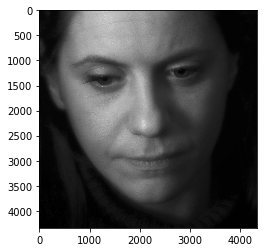

In [106]:
plt.imshow(img)

In [107]:
def get_points(df,filename):
    points = df[df['filename'] == filename].values[:,1:]
    return points.reshape( (14,2) )

In [108]:
points = get_points(labels_df, test_filename)

In [109]:
def draw_points(img,points,radius=1):
    new_img = img.copy()
    for point in points:        
        new_img = cv2.circle(new_img,(point[0],point[1]), radius, (255,0,0), -1)
    return new_img

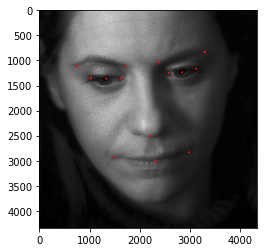

In [111]:
img1 = draw_points(img,points,20)
plt.imshow(img1)

### Resize

In [113]:
INPUT_SIZE = (96,96,1)

In [114]:
def resize(img,points=None,size=INPUT_SIZE):
    rx = size[0] / img.shape[1]
    ry = size[1] / img.shape[0]
    
    new_points = np.zeros(points.shape)
    new_points[:,0] = points[:,0] * rx
    new_points[:,1] = points[:,1] * ry

    new_img = cv2.resize(img, size[:-1] )
    return cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY), new_points.astype(int)

In [115]:
img, points = resize(img, points)

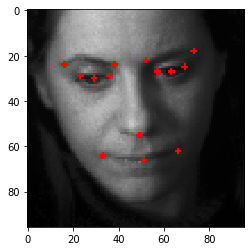

In [118]:
img1 = draw_points(np.stack((img,)*3, axis=-1),points)

plt.imshow(img1)

### Normalize

In [19]:
def normalize(img,points):
    return img / 255, points / INPUT_SIZE[0]

### Augmentation

* Flip
* Rotation
* Shear
* Translation

In [298]:
def transform_image(img,points,ang_range=15,shear_range=10,trans_range=5,flip=True):
    rows,cols = img.shape[0],img.shape[1]
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[40,5],[5,40]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 40+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,rot_M,(cols,rows),borderMode = cv2.BORDER_REPLICATE)
    new_points = cv2.transform(np.array([points]),rot_M)
    img = cv2.warpAffine(img,trans_M,(cols,rows),borderMode = cv2.BORDER_REPLICATE)
    new_points = cv2.transform(new_points,trans_M)
    img = cv2.warpAffine(img,shear_M,(cols,rows),borderMode = cv2.BORDER_REPLICATE)
    new_points= cv2.transform(new_points,shear_M)
    new_points = new_points[0]
    
    #     Flip
    if flip is True and round(np.random.uniform()) == 1:
        img = cv2.flip(img, 1)
        new_points[:,0] = cols - new_points[:,0]

    return img, new_points

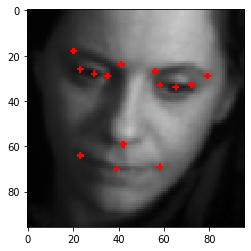

In [125]:
img2,points2 = transform_image(img,points)
img2 = draw_points(np.stack((img2,)*3, axis=-1),points2)
plt.imshow(img2)

### Create data for NN

####  Simple x and y without batches

In [75]:
def get_data(df,aug_count=3):
    x = []
    y = []
    for filename in df['filename']:
        img = cv2.imread(images_data + filename)
        points = get_points(df, filename)  
        img, points = resize(img,points)
        orig_img, orig_points = normalize(img, points)
        x.append(orig_img.reshape(INPUT_SIZE))
        y.append(orig_points.flatten() )
        for _ in range(aug_count):            
            new_img, new_points = transform_image(img,points)            
            new_img, new_points = normalize(new_img,new_points)  
            x.append(new_img.reshape(INPUT_SIZE))
            y.append(new_points.flatten() )
    return np.asarray(x), np.asarray(y)

#### Infinite generator that handles batching

In [63]:
def data_gen(df, batch_size, aug_count=3):
    x_batch = []
    y_batch = []
    while True:        
        for filename in df['filename']:
            img = cv2.imread(images_data + filename)
            points = get_points(df, filename)  
            img, points = resize(img,points)
            orig_img, orig_points = normalize(img, points)  
            x_batch.append( orig_img.reshape(INPUT_SIZE))
            y_batch.append( orig_points.flatten()) 
            for _ in range(aug_count):            
                new_img, new_points = transform_image(img,points,)            
                new_img, new_points = normalize(new_img,new_points)  
                
                x_batch.append( new_img.reshape(INPUT_SIZE))
                y_batch.append( new_points.flatten()) 
                
            if len(x_batch) == batch_size:
                yield np.asarray(x_batch), np.asarray(y_batch)
                x_batch = []
                y_batch = []
  

### Model

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [27]:
# https://github.com/tensorflow/tensorflow/issues/24828#issuecomment-576778701

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Train validation test split

In [28]:
train_df, val_df = train_test_split(labels_df,test_size=0.2, random_state=42)

In [29]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)


In [232]:
train_df.shape,val_df.shape,test_df.shape

((3600, 29), (1000, 29), (400, 29))

In [299]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=INPUT_SIZE),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(64, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(96, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(96, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(128, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(256, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(512, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    
    layers.Conv2D(512, (3,3), padding='same', use_bias=False),
    layers.LeakyReLU(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(512),
    layers.Dropout(0.1),
    layers.Dense(28,activation='sigmoid'),
])


In [300]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)       

In [301]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.003),
              loss='mean_squared_error',
              metrics=['mae'])

In [302]:
batch_size = 64
aug_count = 7
steps = (len(train_df) * (aug_count + 1)) // batch_size
val_steps = len(val_df) // batch_size
steps, val_steps

(450, 15)

In [303]:
history = model.fit(data_gen(train_df,batch_size,aug_count), 
                    epochs = 40, 
                    steps_per_epoch = steps, 
                    validation_data = data_gen(val_df, batch_size, 0),
                    validation_steps = val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 450 steps, validate for 15 steps
Epoch 1/40
450/450 [==============================] - 55s 123ms/step - loss: 0.0322 - mae: 0.1314 - val_loss: 0.0208 - val_mae: 0.1020
Epoch 2/40
450/450 [==============================] - 54s 120ms/step - loss: 0.0182 - mae: 0.0970 - val_loss: 0.0080 - val_mae: 0.0643
Epoch 3/40
450/450 [==============================] - 54s 121ms/step - loss: 0.0116 - mae: 0.0715 - val_loss: 0.0058 - val_mae: 0.0528
Epoch 4/40
450/450 [==============================] - 55s 121ms/step - loss: 0.0083 - mae: 0.0573 - val_loss: 0.0117 - val_mae: 0.0703
Epoch 5/40
450/450 [==============================] - 54s 121ms/step - loss: 0.0072 - mae: 0.0523 - val_loss: 0.0039 - val_mae: 0.0409
Epoch 6/40
450/450 [==============================] - 54s 121ms/step - loss: 0.0060 - mae: 0.0470 - val_loss: 0.0053 - val_mae: 0.0456
Epoch 7/40
450/450 [==============================] - 54s 120ms/step - loss: 0.0053 - mae: 0.0439

### Evalute on test

In [304]:
test_x, test_y  = get_data(test_df,0)

In [305]:
predicted = model.predict(test_x)

In [306]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [307]:
mean_squared_error(test_y , predicted) 

0.0016635027714969176

In [308]:
mean_absolute_error(test_y , predicted) 

0.02511755847349941

In [309]:
len(train_df) * (aug_count + 1)

28800

With no augmentation, Trained on 3600 (original) samples.  -  MSE: 0.0008

With slight (10,5,5) augmentation, Trained on 14400 (3 more augmented per sample) samples.  -  MSE: 0.0064

With slight (10,5,5) augmentation, Trained on 14400 (3 more augmented per sample) samples. Very tough model  -  MSE: 0.0021

With (15,10,5) augmentation, Trained on 28800 (7 more augmented per sample) samples. Very tough model  -  MSE: 0.0016

#### Show some predictions

In [310]:
from sklearn.utils import shuffle

In [311]:
def show_predictions(test_x,predicted, n=6):
    show_x, show_y = shuffle(test_x, predicted)
    plt.figure(1, figsize=(16,9))
    for i, (img, points) in enumerate(zip(show_x[:n,:],show_y[:n,:] )):
        new_img = (img * 255).reshape(img.shape[:2]).astype(int)
        draw = draw_points( np.stack((new_img,)*3, axis=-1), (points * 96).reshape(14,2).astype(int) )
        plt.subplot(3,3,i+1)
        plt.imshow(draw) 

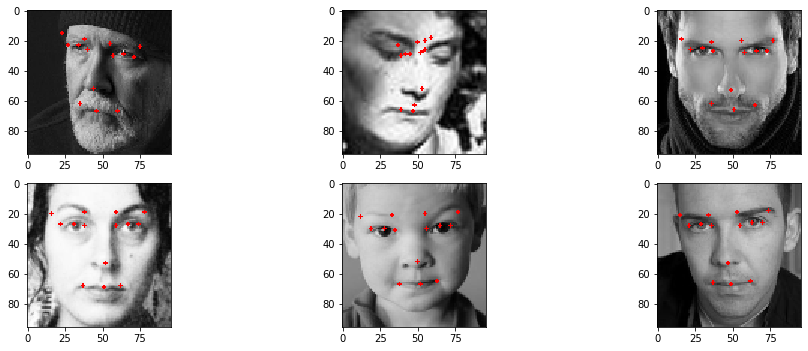

In [319]:
show_predictions(test_x,predicted)

### Predict

In [320]:
import os

In [321]:
test_folder = './data/test/'

In [322]:
final_df = pd.DataFrame({'filename': os.listdir(test_folder)}, columns=labels_df.columns)

In [323]:
final_x = []
for fn in final_df['filename']:
    img = cv2.imread(test_folder + fn)
    img = cv2.resize(img, INPUT_SIZE[:-1] )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_x.append(img.reshape(INPUT_SIZE) / 255)
final_x = np.asarray(final_x)

In [324]:
final_pred = model.predict(final_x) 

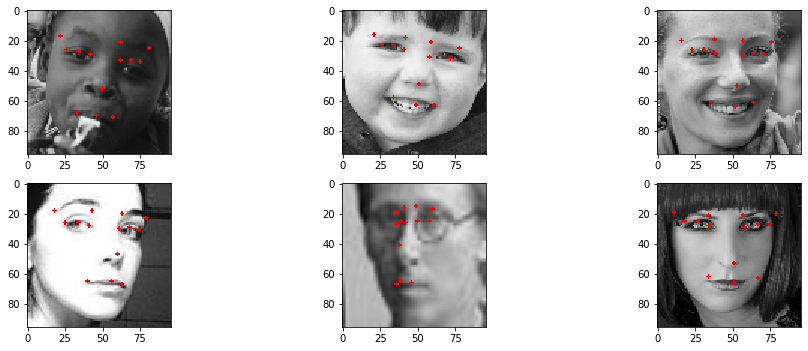

In [330]:
show_predictions(final_x,final_pred)

In [326]:
final_df.iloc[:,1:] = (final_pred * 96).astype(int)

In [327]:
final_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00008.jpg,18,18,41,16,59,18,76,24,24,...,70,32,54,40,35,59,51,60,60,62
1,00014.jpg,8,36,27,25,45,17,61,13,16,...,60,22,55,43,44,67,59,60,67,56
2,00015.jpg,18,16,38,19,55,21,74,24,23,...,68,30,49,44,34,53,48,57,59,59
3,00017.jpg,8,29,26,25,47,18,70,14,15,...,68,23,46,49,38,65,53,64,69,58
4,00023.jpg,14,23,35,21,54,19,69,18,21,...,65,25,54,50,38,62,53,64,63,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,05948.jpg,16,24,36,19,54,17,70,17,22,...,67,26,52,47,40,70,52,67,60,67
996,05959.jpg,13,35,28,28,42,20,50,13,20,...,51,21,50,48,43,64,53,60,58,53
997,05961.jpg,18,22,37,19,56,18,72,18,23,...,70,25,51,48,35,63,51,64,64,61
998,05968.jpg,10,34,29,26,48,19,66,13,18,...,65,22,53,50,42,66,58,63,69,56


In [178]:
final_df.to_csv('submission.csv')